## ETL (Python + SQL)

<div class="alert alert-block alert-info"
<b>
Применим знания на практике: с помощью pandahous попробуем выгрузить нужные данные из ClickHouse и проанализируем их в python. 

Импортируем библиотеки:

</b>
</div

In [66]:
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

<div class="alert alert-block alert-info"
<b>
Далее создаем словарь connection с нужными параметрами:

</b>
</div

In [67]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

<div class="alert alert-block alert-info"
<b>

**1.Для начала, проверим правильность подключения к ClickHouse через pandahouse, отправив простой запрос: выведите количество строк в таблице ldn_listings.**

</b>
</div

In [68]:
# создаем запрос, db автоматически заменится на значение из database
q = '''
    SELECT 
        COUNT(*) 
    FROM 
        {db}.ldn_listings 
    '''

In [69]:
# отправляем запрос и записываем результат в пандасовский датафрейм
q_test = ph.read_clickhouse(query=q, connection=connection_default)
q_test

,count()
0,85207


<div class="alert alert-block alert-info"
<b>

**2.Выгрузите из таблицы данные о цене в зависимости от типа жилья.** 
**Необходимые столбцы:**
* **price** – цена за ночь
* **room_type** – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)

**Ограничение поставьте на 1000 строк. Результат должен быть отсортирован по возрастанию id.**

</b>
</div

In [70]:
q_2 = '''
    SELECT 
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price
    FROM 
        {db}.ldn_listings 
    ORDER BY id ASC
    LIMIT 1000
    '''

<div class="alert alert-block alert-info"
<b>

**Сгруппируйте полученный датафрейм по типу жилья и посчитайте 75-й перцентиль цены.**

</b>
</div

In [71]:
q_2_result = ph.read_clickhouse(query=q_2, connection=connection_default)
q_2_result.head()

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Entire home/apt,300.0
3,Private room,150.0
4,Entire home/apt,65.0


In [72]:
q_75_quan = q_2_result.groupby('room_type')['price'].quantile(q=0.75).reset_index()
q_75_quan

,room_type,price
0,Entire home/apt,160.00
1,Hotel room,157.00
2,Private room,70.00
3,Shared room,69.25


<div class="alert alert-block alert-info"
<b>

**3.К данным о цене и типе комнаты дополнительно выгрузите данные о рейтинге жилья (review_scores_rating).** 
**В запросе необходимо будет отфильтровать пустые значения review_scores_rating и сконвертировать эту колонку в тип float32.**

**Давайте построим график рассеивания, который покажет зависимость средней оценки от средней цены по типу жилья.**

* **сгруппируйте датафрейм по типу жилья и посчитайте среднее для цены и рейтинга (не забудьте привести рейтинг к типу float)**
* **используйте sns.scatterplot, чтобы построить график рассеивания средней цены (ось X) и рейтинга (ось Y) c разбивкой 
по типу жилья (параметр hue)**

</b>
</div

In [73]:
q_3 = '''
    SELECT 
        room_type,
        toFloat32OrNull(review_scores_rating) as review_scores_rating,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price
    FROM 
        {db}.ldn_listings 
    WHERE review_scores_rating IS NOT NULL
    ORDER BY id ASC
    LIMIT 1000
    '''

In [74]:
q_3_result = ph.read_clickhouse(query=q_3, connection=connection_default)
q_3_result.head()

,room_type,review_scores_rating,price
0,Private room,97.0,65.0
1,Entire home/apt,96.0,100.0
2,Entire home/apt,94.0,300.0
3,Entire home/apt,93.0,65.0
4,Private room,96.0,29.0


In [75]:
q_3_agg = q_3_result.groupby('room_type',as_index=False).agg({'price':'mean','review_scores_rating':'mean'})
q_3_agg

,room_type,price,review_scores_rating
0,Entire home/apt,135.882950,93.568787
1,Hotel room,134.000000,92.500000
2,Private room,54.642437,94.766205
3,Shared room,21.000000,90.000000


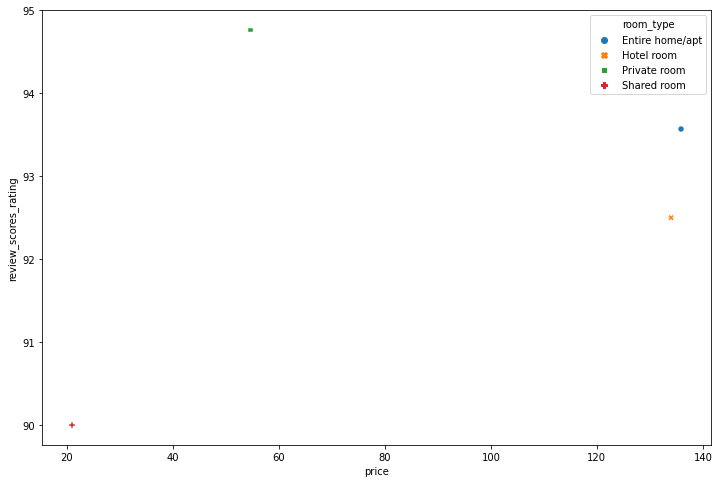

In [76]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=q_3_agg, x="price", y="review_scores_rating", hue="room_type", style="room_type")

<div class="alert alert-block alert-info"
<b>

**4.Итак, помимо аренды жилья, на Airbnb также есть "Впечатления" — мероприятия, которые организуют местные жители.**

**Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления** 
**(experiences_offered != 'none'). Для каждого уникального пользователя выгрузите только две колонки:**

* **host_id** – идентификатор хозяина (уникальный)
* **host_verifications** – какими способами хост подтвердил свой профиль

**Затем обработайте столбец host_verifications:**
* **В ячейках находятся строковые представления списка (например, как результат str([1, 2, 3])).** 
**Приведите их к настоящему списку, где в качестве элементов будут храниться использованные способы подтверждения аккаунта:** **"['email', 'phone', 'facebook']" -> ['email', 'phone', 'facebook']**
* **Используйте методы explode и value_counts, чтобы посчитать, сколько раз встречается каждый способ верификации**

</b>
</div

In [77]:
q_4 = '''
    SELECT 
        DISTINCT 
        host_id, 
        host_verifications
    FROM 
        {db}.ldn_listings 
    WHERE experiences_offered != 'none'
    LIMIT 1000
    '''

In [78]:
q_4_result = ph.read_clickhouse(query=q_4, connection=connection_default)
q_4_result.head()

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."


In [79]:
q_4_agg = q_4_result\
        .host_verifications\
        .apply(lambda x: x.strip('[]').replace("'","").split(','))\
        .explode()\
        .value_counts()

In [80]:
q_4_agg

email                     991
 phone                    991
 reviews                  978
 government_id            888
 jumio                    819
 offline_government_id    356
 facebook                 218
 work_email               212
 selfie                   190
 identity_manual          169
 manual_offline            55
 google                    26
 kba                       25
 manual_online             12
phone                       9
 sent_id                    5
Name: host_verifications, dtype: int64

<div class="alert alert-block alert-info"
<b>

**5.Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления.** 
**Сгруппируйте данные по району и виду впечатления и посчитайте количество объявлений.** 
**Новый столбец назовите experiences_count.**

**Отсортируйте данные по убыванию experiences_count и выгрузите первые 100 строк.** 
**Затем преобразуйте данные с помощью pivot, поместив в индексы название района,** 
**столбцы – вид впечатления, а значения – число объявлений с таким впечатлением для каждого района.**
**Визуализируйте результат с помощью sns.heatmap() c палитрой cmap=sns.cubehelix_palette(as_cmap=True).**

</b>
</div

In [81]:
q_5 = '''
    SELECT 
        neighbourhood_cleansed,
        experiences_offered, 
        COUNT(*) as experiences_count
    FROM 
        {db}.ldn_listings 
    WHERE experiences_offered != 'none'
    GROUP BY neighbourhood_cleansed, experiences_offered
    ORDER BY experiences_count DESC
    LIMIT 100
    '''

In [82]:
q_5_result = ph.read_clickhouse(query=q_5, connection=connection_default)
q_5_result.head()

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48


In [83]:
q_5_pivot = q_5_result.pivot(index='neighbourhood_cleansed',columns='experiences_offered',values='experiences_count')

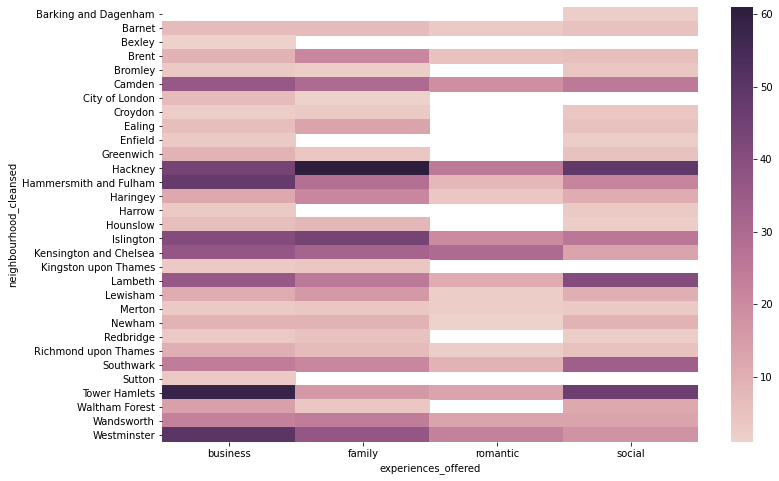

In [84]:
plt.figure(figsize=(12, 8))
q_5_heatmap = sns.heatmap(q_5_pivot, cmap=sns.cubehelix_palette(as_cmap=True))
q_5_heatmap

<div class="alert alert-block alert-info"
<b>

**6.Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления.** 

**Необходимые для составления запроса столбцы:**
* **room_type** – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
* **price** – цена за ночь 
* **experiences_offered** – вид доступного впечатления (оставить не 'none')

</b>
</div

In [85]:
q_6 = '''
    SELECT 
        toFloat32OrNull(replaceRegexpAll(price, '[$,]','')) as price_corr,
        room_type
    FROM 
        {db}.ldn_listings 
    WHERE experiences_offered != 'none'
    '''

In [86]:
q_6_result = ph.read_clickhouse(query=q_6, connection=connection_default)
q_6_result.head()

,price_corr,room_type
0,65.0,Private room
1,100.0,Entire home/apt
2,150.0,Private room
3,45.0,Private room
4,25.0,Private room


<div class="alert alert-block alert-info"
<b>

**Далее постройте два графика, используя distplot из библиотеки seaborn:**

* **На первом отобразите исходные распределения цен для каждого типа жилья**
* **На втором – логарифмированные значения (np.log())**

</b>
</div

In [87]:
q_6_result.room_type.value_counts()

Entire home/apt    922
Private room       613
Shared room          9
Hotel room           4
Name: room_type, dtype: int64

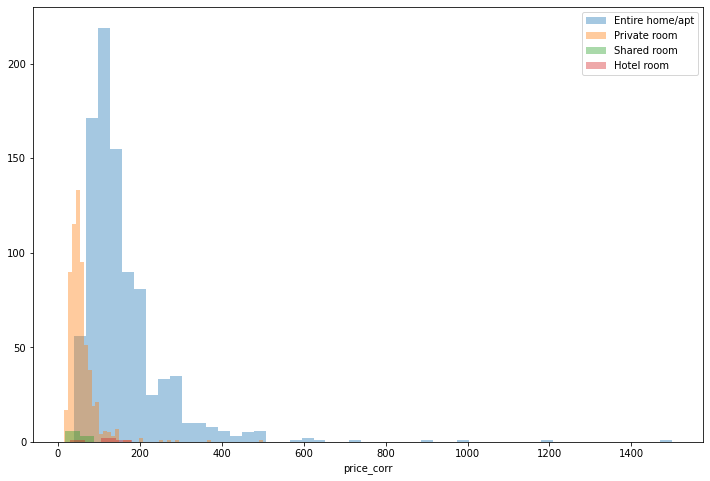

In [88]:
plt.figure(figsize=(12, 8))
sns.distplot(q_6_result.query("room_type=='Entire home/apt'").price_corr, kde=False, label='Entire home/apt')
sns.distplot(q_6_result.query("room_type=='Private room'").price_corr, kde=False, label='Private room')
sns.distplot(q_6_result.query("room_type=='Shared room'").price_corr, kde=False, label='Shared room')
sns.distplot(q_6_result.query("room_type=='Hotel room'").price_corr, kde=False, label='Hotel room')
plt.legend()
plt.show()

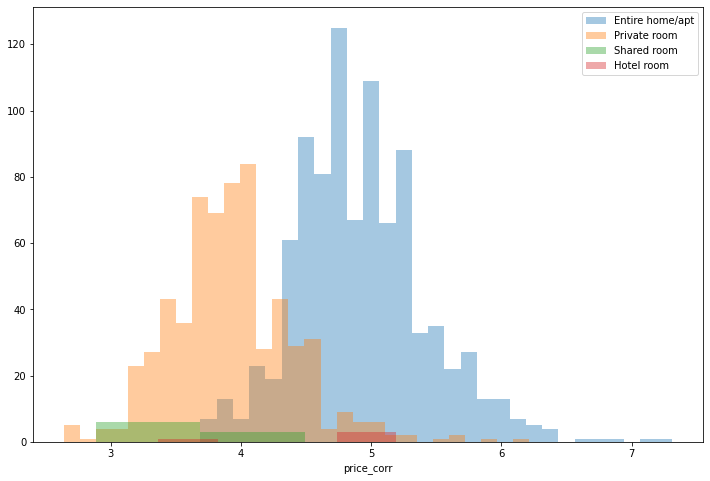

In [89]:
plt.figure(figsize=(12, 8))
sns.distplot(np.log(q_6_result.query("room_type=='Entire home/apt'").price_corr), kde=False, label='Entire home/apt')
sns.distplot(np.log(q_6_result.query("room_type=='Private room'").price_corr), kde=False, label='Private room')
sns.distplot(np.log(q_6_result.query("room_type=='Shared room'").price_corr), kde=False, label='Shared room')
sns.distplot(np.log(q_6_result.query("room_type=='Hotel room'").price_corr), kde=False, label='Hotel room')
plt.legend()
plt.show()

<div class="alert alert-block alert-info"
<b>

**7.Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года.** 

**Необходимые столбцы:**
* **room_type** – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
* **price** – цена за ночь
* **first_review** – дата первого отзыва (отфильтровать по правилу "строго больше 2010-01-01")
* **Ограничение поставьте на 1000 строк.**

</b>
</div

In [90]:
q_7 = '''
    SELECT 
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]','')) as price_corr,
        first_review
    FROM 
        {db}.ldn_listings 
    WHERE first_review > ' 2010-01-01'
    LIMIT 1000
    '''

In [91]:
q_7_result = ph.read_clickhouse(query=q_7, connection=connection_default)
q_7_result.head()

,room_type,price_corr,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,100.0,2009-12-21
2,Entire home/apt,300.0,2011-03-21
3,Entire home/apt,65.0,2016-03-05
4,Private room,29.0,2010-04-14


<div class="alert alert-block alert-info"
<b>

**Используя библиотеку seaborn и функцию lineplot, постройте график динамики средних цен на жилье (ось Y)**
**в зависимости от типа комнаты (цвет линии, параметр 'hue') по годам (ось X).**
**Датафрейм должен быть отсортирован по годам.**

</b>
</div

In [92]:
q_7_result.first_review = pd.to_datetime(q_7_result.first_review).dt.to_period('y')

In [93]:
q_7_result.first_review = q_7_result.first_review.astype('str')

In [94]:
q_7_agg = q_7_result.groupby(['room_type','first_review'],as_index=False).agg({'price_corr':'mean'})
q_7_agg.head()

,room_type,first_review,price_corr
0,Entire home/apt,2009,100.000000
1,Entire home/apt,2010,103.500000
2,Entire home/apt,2011,128.792450
3,Entire home/apt,2012,135.467255
4,Entire home/apt,2013,137.887634


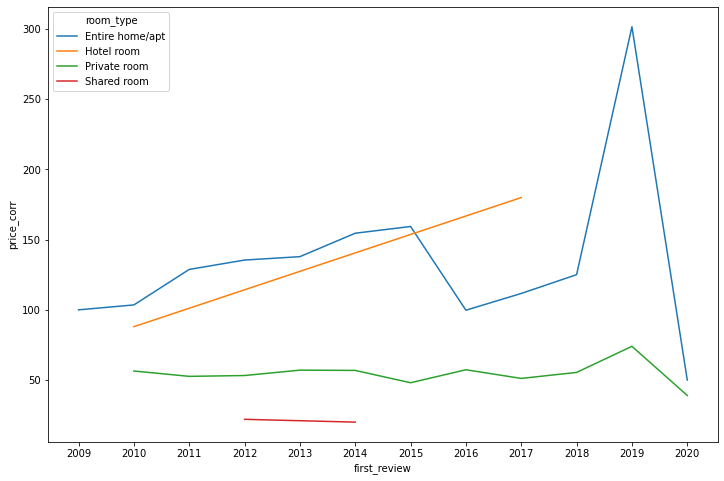

In [96]:
plt.figure(figsize=(12, 8))
sns.lineplot(x='first_review',y='price_corr',hue='room_type',data=q_7_agg)